In [1]:
import os
import sys
import math

# Путь к директории, где находится текущий ноутбук
NOTEBOOK_DIR = os.path.abspath(os.path.dirname("__file__"))  # работает в Jupyter

# Поднимаемся на один уровень вверх – получаем корень проекта
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir, 'src'))

# Добавляем корень в начало sys.path, если его там ещё нет
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [2]:
# tests/test_feature_id_hole.py
import math

from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Ax2
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox, BRepPrimAPI_MakeCylinder
from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Cut

from afr3d.drafting.model import DraftCurveKind, CoverageKind
from afr3d.drafting.views import build_linear_view
from afr3d.drafting.drafting_vertices import build_topology_view_with_hlr_segments
from afr3d.drafting.circles import rebuild_all_circles, apply_hlr_visibility_to_circles

from afr3d.drafting.model import HoleAFR


def make_box_with_through_hole():
    """
    Делает прямоугольный параллелепипед 100x80x20 с одним сквозным отверстием Ø20 по центру.
    """
    box = BRepPrimAPI_MakeBox(100.0, 80.0, 20.0).Shape()

    cyl_axis = gp_Ax2(
        gp_Pnt(50.0, 40.0, -10.0),   # центр в XY, ось вдоль Z
        gp_Dir(0.0, 0.0, 1.0),
    )
    hole_cyl = BRepPrimAPI_MakeCylinder(cyl_axis, 10.0, 40.0).Shape()  # R=10, длина 40

    shape = BRepAlgoAPI_Cut(box, hole_cyl).Shape()

    # AFR для отверстия (минимальный)
    hole = HoleAFR(
        id=1,
        name="test_through_hole",
        # сюда те поля, которые у тебя реально есть (радиус, ось и т.п.)
    )
    hole.feature_id = "hole:1"

    return shape, [hole]


def make_front_ax2():
    # фронтальный вид: смотрим против +Z, X вправо, Y вверх
    return gp_Ax2(
        gp_Pnt(0, 0, 0),
        gp_Dir(0, 0, 1),
        gp_Dir(1, 0, 0),
    )


def make_top_ax2():
    # вид сверху: смотрим против +Y, X вправо, Z вверх
    return gp_Ax2(
        gp_Pnt(0, 0, 0),
        gp_Dir(0, 1, 0),
        gp_Dir(1, 0, 0),
    )


def _build_view(shape, ax2, holes_afr):
    # 1) HLR-сегменты
    segments = build_linear_view(shape, ax2)

    # 2) топологический вид по рёбрам
    view_edges = build_topology_view_with_hlr_segments(
        shape=shape,
        view_name="+test",
        ax2=ax2,
        hlr_segments=segments,
        feature_edge_map=None,  # пока не размечаем рёбра
    )

    # 3) окружности по AFR отверстий
    view_with_circles = rebuild_all_circles(
        view=view_edges,
        shape=shape,
        holes=holes_afr,
    )

    # 4) HLR-маска видимости окружностей
    view_final = apply_hlr_visibility_to_circles(
        view=view_with_circles,
        hlr_segments=segments,
        debug=False,
    )
    return view_final


def test_feature_id_propagates_to_front_view():
    shape, holes = make_box_with_through_hole()
    front_ax2 = make_front_ax2()

    view = _build_view(shape, front_ax2, holes)

    # ищем окружности/дуги с feature_id="hole:1"
    hole_curves = [
        c for c in view.curves
        if c.feature_id == "hole:1" and c.kind in (DraftCurveKind.CIRCLE, DraftCurveKind.ARC)
    ]

    assert len(hole_curves) > 0, "На фронтальном виде нет ни одной окружности/дуги отверстия"

    # проверим, что хотя бы одна имеет coverage != NONE
    assert any(c.coverage != CoverageKind.NONE for c in hole_curves)


def test_feature_id_propagates_to_top_view():
    shape, holes = make_box_with_through_hole()
    top_ax2 = make_top_ax2()

    view = _build_view(shape, top_ax2, holes)

    hole_curves = [
        c for c in view.curves
        if c.feature_id == "hole:1" and c.kind in (DraftCurveKind.CIRCLE, DraftCurveKind.ARC)
    ]

    # на виде сверху дырка тоже должна "просвечивать"
    assert len(hole_curves) > 0

In [3]:
from afr3d.io.step_import import load_step
from afr3d.drafting.views import select_main_views, build_linear_view, extract_solids
from afr3d.features import analyze_part
from afr3d.drafting.analytic import build_analytic_view_from_topology
from afr3d.drafting.circles import rebuild_circles_from_hlr_analytic
from afr3d.drafting.model import DraftView2D

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from afr3d.drafting.model import DraftView2D, DraftCurveKind

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="OCC")

In [4]:
shape_raw = load_step("../data/simple_model.stp")
shape = extract_solids(shape_raw)

part_analysis = analyze_part(shape)   # как у тебя в CLI
holes_afr = part_analysis.holes      # список HoleAFR

view_set = select_main_views(shape)

[HLR] edges_total=180, with_coverage=92, no_coverage=0
[HLR] subedges_total=218 (vis=192, hid=26)
[HLR] lengths: L_vis=3504.486789, L_hid=1340.700510
[CIRC HLR] circle at (94.925,-2.133), R=10.000: uncovered_len=61.690582, coverage=PARTIAL
[CIRC HLR] circle at (59.672,-65.624), R=15.000: no coverage
[CIRC HLR] circle at (59.496,-65.495), R=0.000: no coverage
[CIRC HLR] circle at (59.665,-65.618), R=12.500: uncovered_len=0.180591, coverage=PARTIAL
[CIRC HLR] circle at (59.519,-65.511), R=12.500: uncovered_len=0.180591, coverage=PARTIAL
[CIRC HLR] circle at (94.925,-2.133), R=10.000: uncovered_len=61.690582, coverage=PARTIAL


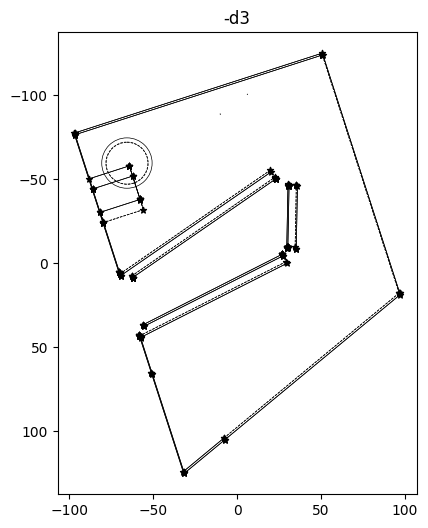

In [5]:
from afr3d.drafting.views import build_linear_view
from afr3d.drafting.drafting_vertices import build_topology_view_with_hlr_segments
from afr3d.drafting.circles import rebuild_all_circles, apply_hlr_visibility_to_circles
from afr3d.drafting.plotting import plot_analytic_view_with_vertices
from afr3d.drafting.model import VIEW_ROTATION
from afr3d.drafting.drafting_vertices import add_vertices_from_topology
from afr3d.drafting.plotting import (
    plot_analytic_view_with_vertices,
    rotate_point_deg,
)
from afr3d.drafting.views import generate_six_obb_views

view_defs = generate_six_obb_views(shape)

vdef = view_defs[5]

segments = build_linear_view(shape, vdef.ax2)

view_edges = build_topology_view_with_hlr_segments(
    shape=shape,
    view_name=vdef.name,
    ax2=vdef.ax2,
    hlr_segments=segments,
)

view_with_circles = rebuild_all_circles(
    view=view_edges,
    shape=shape,
    holes=holes_afr,
)

view_final = apply_hlr_visibility_to_circles(
    view=view_with_circles,
    hlr_segments=segments,
    debug=True,
)

fig, ax = plt.subplots(figsize=(8, 6))
plot_analytic_view_with_vertices(
    ax,
    view_final,
    title=view_final.name,
    show_hidden=True,
)
plt.show()

In [ ]:
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox, BRepPrimAPI_MakeCylinder
from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Cut
from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Ax2

try:
    from OCC.Display.WebGl.jupyter_renderer import JupyterRenderer
except ImportError:
    from OCC.Display.JupyterRenderer import JupyterRenderer


def make_box_with_hole():
    box = BRepPrimAPI_MakeBox(100, 80, 20).Shape()

    axis = gp_Ax2(
        gp_Pnt(50, 40, -10),
        gp_Dir(0, 0, 1),
    )
    cyl = BRepPrimAPI_MakeCylinder(axis, 10, 40).Shape()

    return BRepAlgoAPI_Cut(box, cyl).Shape()


shape = make_box_with_hole()
renderer = JupyterRenderer()

renderer.DisplayShape(shape)

#renderer.Display()  # <<< ВАЖНО: это выводит виджет